## 2025-07-29 Mixture model example in one dimension, now with loops ##

Altered from Dan Foreman-Mackey's excellent post [10.5281/zenodo.15856](http://dx.doi.org/10.5281/zenodo.15856) . Most of the useful and eloquent explanatory material from that post has been removed here, but everyone should read the original.

Main aim here: generate 1D example with degree 2, fit with a range of degrees (from 0 to 6, say), and use the resulting collection of samplers to test the performance of model selection statistics, particularly WAIC and LOO, on datasets we can easily visualize. In particular: 

* loops through fit degrees for the same dataset (now at the end);
* This notebook dumps samplers to .pickle files. Alter argument "deg" to change the fit degree.
    *  A separate notebook then loads the collection. (Currently notebook **2025-07-29_compare_emcee.ipynb**)
    * when reading in the samplers, will need to import the methods too.
* The aim is to use the **arviz** library to do the work of computing the ''standard'' (but not trivial) statistics for us.
    * A sample call to **arviz** is included at the bottom of this notebook so that we can check that the output is reasonable.
* We use **emcee**'s blobs functionality to attach the per-object, per-step log-likelihood values.

## Set up a few particulars we will need ##

In [1]:
# fit degree, number of datapoints, etc.
deg=2
chainlen = 2500
burnin = 1500 # we're not really worried about efficiency, these are small samples
ndata = 40
sigma_outly=2.0
ranseed=12  # dfm's example uses 12

# ranseed=132546  # uncomment this to set your own

# allow generating data with more than linear parameters
deg_gen = 2

# we'll pre-cook a set of parameters now and just select out the ones we want
truths_big = [-0.02, 0.30, 1.0, 0.0] # highest power first
true_params = truths_big[-(deg_gen+1)::]

# true inlier fraction
true_frac = 0.8

# The outliers are drawn from a Gaussian with zero mean and supplied variance:
true_outliers = [0.0, sigma_outly]

# construct filename for samples, so that we can easily find them as a set 
ssamples = 'ndata%i_outly%.1f_gen%i_fit%i' % (ndata,sigma_outly, deg_gen, deg)

path_samples_out = 'samples_%s.pickle' % (ssamples)
print(path_samples_out)

samples_ndata40_outly2.0_gen2_fit2.pickle


In [2]:
import numpy as np
import matplotlib.pyplot as pl

# TRUE PARAMS NOW SET ABOVE
# The linear model has unit slope and zero intercept:
# true_params = [1.0, 0.0]

# express this in terms of the polynomial model
true_poly = np.zeros(deg+1)
if len(true_poly) >= len(true_params):
    true_poly[-len(true_params)::] = true_params
else:
    true_poly = true_params[-(len(true_poly))::]

print("DEBUG:")
print("true_params:", true_params)
print("true_poly:", true_poly)


# For reproducibility, let's set the random number seed and generate the data:
#np.random.seed(12)
np.random.seed(ranseed)
x = np.sort(np.random.uniform(-2, 2, ndata))

yerr = 0.2 * np.ones_like(x)

## uncty for outliers
#yerr_outly = 2.

# y = true_params[0] * x + true_params[1] + yerr * np.random.randn(len(x))

# use polyval to do this
y = np.polyval(true_params, x) + yerr * np.random.randn(len(x))

# Those points are all drawn from the correct model so let's replace some of
# them with outliers.
#
# m_bkg = np.random.rand(len(x)) > true_frac
#
# WIC - do this a bit more deterministically
nbkg = int((1.0-true_frac)*len(x))
ldum = np.argsort(np.random.uniform(size=len(x)))
m_bkg = np.repeat(False, np.size(x))
m_bkg[ldum[0:nbkg]] = True

y[m_bkg] = true_outliers[0]
y[m_bkg] += np.sqrt(true_outliers[1] + yerr[m_bkg] ** 2) * np.random.randn(sum(m_bkg))

DEBUG:
true_params: [0.3, 1.0, 0.0]
true_poly: [0.3 1.  0. ]


In [3]:
#np.log(yerr_outly)

Here's what these data look like. In this plot, the empty, square points are the true outliers. The purple line is the fit if we don't account for the fact that there are outliers and just treat all the points equally. Compare this to the correct answer (shown as the black line).

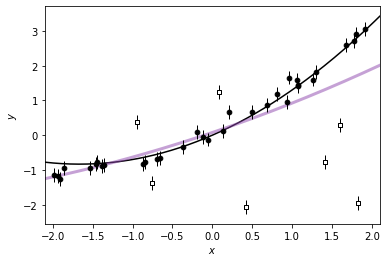

In [4]:
# First, fit the data and find the maximum likelihood model ignoring outliers.

# COMMENT - this requires updating too...

# 
A = np.vander(x, deg+1)
p = np.linalg.solve(np.dot(A.T, A / yerr[:, None] ** 2), np.dot(A.T, y / yerr**2))

# Then save the *true* line.
x0 = np.linspace(-2.1, 2.1, 200)
y0 = np.dot(np.vander(x0, deg_gen+1), true_params)

# Plot the data and the truth.
pl.errorbar(x, y, yerr=yerr, fmt=",k", ms=0, capsize=0, lw=1, zorder=999)
pl.scatter(x[m_bkg], y[m_bkg], marker="s", s=22, c="w", edgecolor="k", zorder=1000)
pl.scatter(x[~m_bkg], y[~m_bkg], marker="o", s=22, c="k", zorder=1000)
pl.plot(x0, y0, color="k", lw=1.5)

# Plot the best fit line.
#pl.plot(x0, x0 * p[0] + p[1], color="#8d44ad", lw=3, alpha=0.5)
pl.plot(x0, np.polyval(p,x0), color="#8d44ad", lw=3, alpha=0.5)


pl.xlabel("$x$")
pl.ylabel("$y$")
#pl.ylim(-2.5, 2.5)
pl.xlim(-2.1, 2.1);

*dfm's explanation of the inlier- and outlier-model follows:*

The purple line is *clearly* a terrible fit because we ignored the outliers. To fix this, let's generalize this model and add a binary flag $q_k$ for each data point $k$. If $q_k$ is zero, then the point is "good" and the likelihood is given by the usual Gaussian:

$$p(y_k\,|\,x_k,\,\sigma_k,\,\theta,\,q_k=0) = \frac{1}{\sqrt{2\,\pi\,\sigma_k^2}} \exp \left(-\frac{[y_k - f_\theta (x_k)]^2}{2\,\sigma_k^2}\right)$$

where $f_\theta (x_k) = \theta_1 \, x_k + \theta_2$ is the linear model.

Now, if $q_k = 1$ then the point is an outlier and the likelihood becomes:

$$p(y_k\,|\,x_k,\,\sigma_k,\,\theta,\,q_k=1) = \frac{1}{\sqrt{2\,\pi\,[\sigma_k^2 + \theta_4]}} \exp \left(-\frac{[y_k - \theta_3]^2}{2\,[\sigma_k^2 + \theta_4]}\right) \quad.$$

I have made the simplifying assumption that the outliers are drawn from a single Gaussian with mean $\theta_3$ and variance $\theta_4$. From experience, the results aren't normally very sensitive to the choice of outlier model and the Gaussian model is often good enough but the following derivations will be valid for any model that you choose.

*more explanation follows in [dfm's original post](http://dx.doi.org/10.5281/zenodo.15856).*

In [5]:
import emcee
import time

## Process polynomial degree as a control variable ##

In [6]:
# turned bounds into a method
def getbounds(deg):
    
    """Returns uniform prior bounds"""

    # generalize slightly to allow polynomials of arbitrary degree
    #bounds_poly = [(-0.4, 0.6) for i in range(deg+1)] # what dfm used for m

    bounds_poly = [(-1., 2.) for i in range(deg+1)] # what dfm used for m


    # in the dfm example, we already know what is sensible for the gradient and intercept.
    bounds_poly[-1] = (-0.9, 0.9)
    if len(bounds_poly) > 1:
        bounds_poly[-2] = (0.1,1.9)

    # bounds_nuisance = [(0, 1), (-2.4, 2.4), (-7.2, 5.2)] # dfm originals
    bounds_nuisance = [(0, 1), (-2.4, 5.), (-7.2, 5.2)]

    bounds = bounds_poly + bounds_nuisance
    # print(bounds)

    # hacks to warn off that outlier walker

    if deg < 1:
        bounds[0] = (-2., 2.)

    #if deg > 3:
    #    bounds[0] = (-0.3,0.6)
    #    #bounds[3] = (0.5,1.9)
    
    if deg > 4:
        bounds[-7] = (-0.9,0.9)
        bounds[-8] = (-0.3, 0.3)
        bounds[-9] = (-0.3, 0.3)

    if deg > 5:
        bounds[-10] = (-0.3,0.3)
    
    #if deg > 5:
    #    bounds[-6] = (-1.5, 1.5)
    #    bounds[-8] = (-0.6,0.6)
    #    bounds[-10] = (-0.3, 0.3)
    ##print(bounds)

    return bounds
    

In [7]:
bounds = getbounds(deg)

In [8]:
npars = np.asarray(bounds).shape[0]
print("npars is %i" % (npars))

npars is 6


In [9]:
def genguess(deg):
    
    """Generates guess array"""
    
    p0_poly = np.repeat(0.1, deg+1)
    p0_poly[-1] = 0.5

    p0_nuisance = np.array([0.7, 0.0, np.log(2.0)])
    p0 = np.hstack(( p0_poly, p0_nuisance))
    
    return p0

In [10]:
# generate the initial guess as a modified copy of dfm's original
p0_poly = np.repeat(0.1, deg+1)
p0_poly[-1] = 0.5

p0_nuisance = np.array([0.7, 0.0, np.log(2.0)])
p0 = np.hstack(( p0_poly, p0_nuisance))                       

In [11]:
# we also want to set the truth values appropriately. We generate them like this

# true_poly now set above.
# nextra = deg+1 - 2
# truths_poly = np.hstack(( np.zeros(nextra), true_params ))
truths_nuisance = [true_frac, true_outliers[0], np.log(true_outliers[1])]

truths = np.hstack(( true_poly, truths_nuisance ))
print(truths)

# now we generate the labels for the truths array for the corner plot
labels = ["$m$", "$b$", "$Q$", "$M$", "$\ln V$"]
labels_poly = ["$a_%i$" % i for i in range(deg+1)[::-1]]
labels_nuisance = ["$Q$", "$M$", "$\ln V$"]

labels = labels_poly + labels_nuisance

[0.3        1.         0.         0.8        0.         0.69314718]


## Back to dfm's example. We define the models...##

In [12]:
# When we pickle.load the sampler produced, this cell needs to be called first 
# so that the associated methods are already in memory.


def lnprior(p):
    # We'll just put reasonable uniform priors on all the parameters.
    if not all(b[0] < v < b[1] for v, b in zip(p, bounds)):
        return -np.inf
    return 0


# The "foreground" linear likelihood:
def lnlike_fg(p):
    #m, b, _, M, lnV = p
    #model = m * x + b
    
    # polynomial parameters unpacked programmatically
    M, lnV = p[-2::]
    ppoly = p[0:-3]

    model = np.polyval(ppoly,x)
    
    return -0.5 * (((model - y) / yerr) ** 2 + 2 * np.log(yerr))


# The "background" outlier likelihood - where data itself is generated from a gaussian:
def lnlike_bg(p):
    #_, _, Q, M, lnV = p
    
    # unpack the nuisance parameters
    Q, M, lnV = p[-3::]
    
    var = np.exp(lnV) + yerr**2
    return -0.5 * ((M - y) ** 2 / var + np.log(var))

def lnlike_bg_new(p):
    #m, b, Q, M, lnV = p
    #model = m * x + b + M
    
    Q, M, lnV = p[-3::]
    
    ppoly = p[0:-3]
    model = np.polyval(ppoly, x)
    
    var = np.exp(lnV) + yerr**2
    return -0.5 * ((model - y) ** 2 / var + np.log(var))



# Full probabilistic model.
def lnprob(p):
    #m, b, Q, M, lnV = p

    # I think we only need the Q value here, the rest of the 
    # parameters get passed straight through.
    Q = p[-3]
    
    # First check the prior.
    lp = lnprior(p)
    if not np.isfinite(lp):
        return -np.inf, np.zeros_like(y), np.zeros_like(y), np.repeat(-np.inf, np.size(y))

    # Compute the vector of foreground likelihoods and include the q prior.
    ll_fg = lnlike_fg(p)
    arg1 = ll_fg + np.log(Q)

    # Compute the vector of background likelihoods and include the q prior.
    ll_bg = lnlike_bg(p)
    arg2 = ll_bg + np.log(1.0 - Q)

    # Combine these using log-add-exp for numerical stability.
    ll = np.sum(np.logaddexp(arg1, arg2))

    # We're using emcee's "blobs" feature in order to keep track of the
    # foreground and background likelihoods for reasons that will become
    # clear soon. 
    #
    # WIC - return per-point log-likelihood so that arviz can use it. This is 
    # a small dataset, so we will just include it alongside the inlier- and 
    # outlier-likelihoods
    return lp + ll, arg1, arg2, np.logaddexp(arg1, arg2)

In [13]:
# emcee particulars
# Initialize the walkers at a reasonable location. p0 now set above
ndim, nwalkers = npars, 32

p0 = [p0 + 1e-5 * np.random.randn(ndim) for k in range(nwalkers)]

print("DEBUG: ndim %i, npars %i" % (ndim , npars))

# Set up the sampler.
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

DEBUG: ndim 6, npars 6


In [14]:
sampler

## Run the sampler ##

Comment: with higher-order models, burn-in seems to be longer. So we'll use a longer chain length and actually look for burn-in...

In [15]:
# Run a burn-in chain and save the final location.
state = sampler.run_mcmc(p0, burnin)


/Users/wiclarks/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/Users/wiclarks/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/Users/wiclarks/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/Users/wiclarks/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/Users/wiclarks/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/Users/wiclarks/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeW

In [16]:
# Run the production chain.
t0 = time.time()
sampler.reset()
sampler.run_mcmc(state, chainlen); # WIC - retained the semicolon otherwise lots of screen output
print("INFO - this took %.2e seconds to run" % (time.time()-t0))

INFO - this took 1.47e+01 seconds to run


In [17]:
print(sampler.flatchain.shape)

(80000, 6)


(2500, 32, 6)


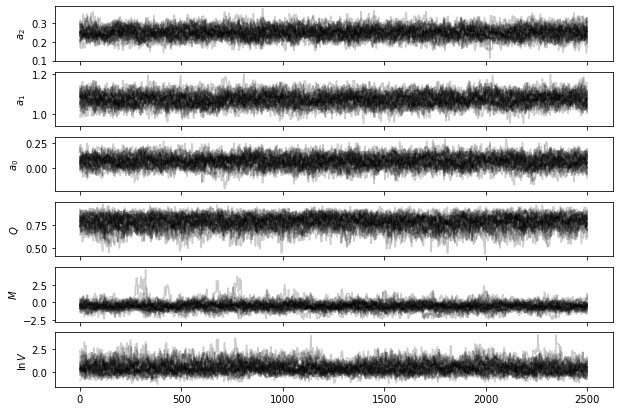

In [18]:
samples = sampler.get_chain()
print(samples.shape)
fig, axes = pl.subplots(samples.shape[-1], figsize=(10, 7), sharex=True)

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.2)
    ax.set_ylabel(labels[i])

*(dfm's comments follow. Computers are a bit faster now than in 2014 when that post was written: on my laptop, the same computation as below took less than a few seconds to run.)*

This code should only take about a minute to run. Compare that to any attempt you've ever made at sampling the same problem with another 15 or more parameters and you should be pretty stoked!

Let's show the resulting parameter constraints and compare them to the *true* values (indicated in blue) used to generate the synthetic dataset. This should encourage us that we've done something reasonable.

['$a_2$', '$a_1$', '$a_0$', '$Q$', '$M$', '$\\ln V$']
[(-1.0, 2.0), (0.1, 1.9), (-0.9, 0.9), (0, 1), (-2.4, 5.0), (-7.2, 5.2)]
(6,)


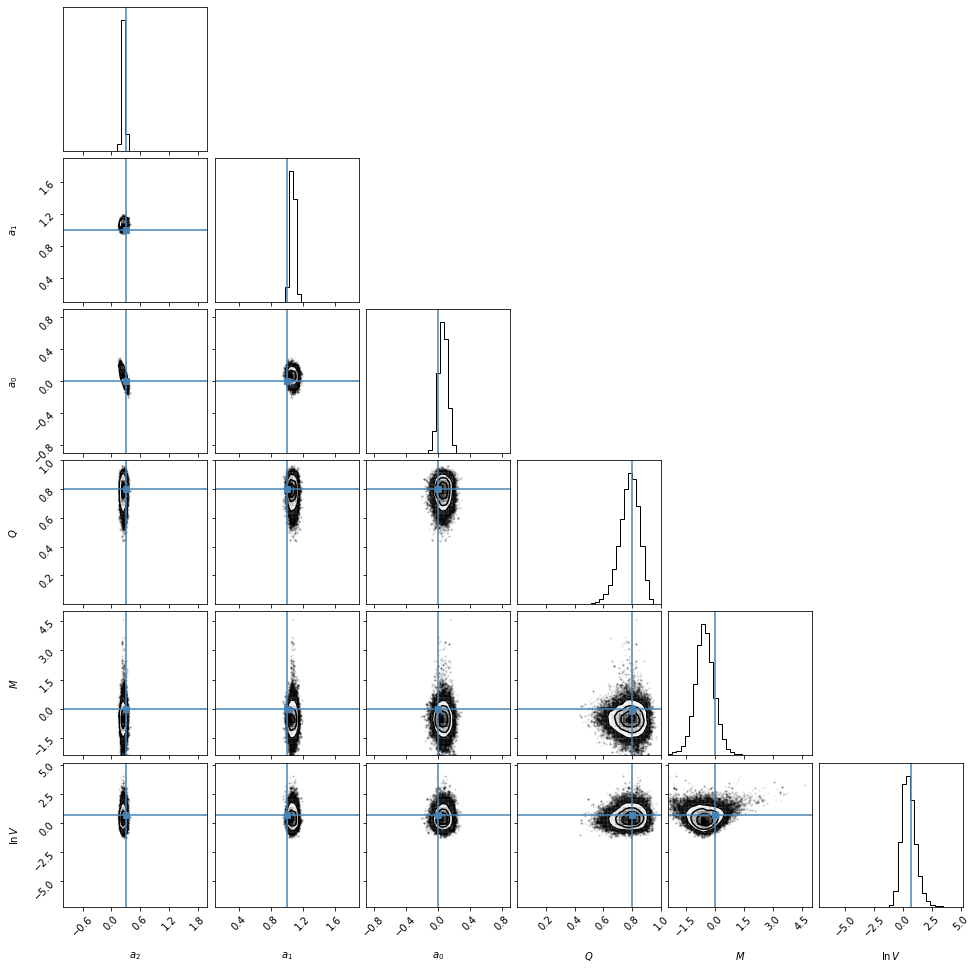

In [19]:
import corner

# labels and truths now determined programmatically above.

print(labels)
print(bounds)
print(truths.shape)

#labels = ["$m$", "$b$", "$Q$", "$M$", "$\ln V$"]
#truths = true_params + [true_frac, true_outliers[0], np.log(true_outliers[1])]
corner.corner(sampler.flatchain, bins=35, range=bounds, labels=labels, truths=truths);

Similarly, the predicted constraint on the linear model is:

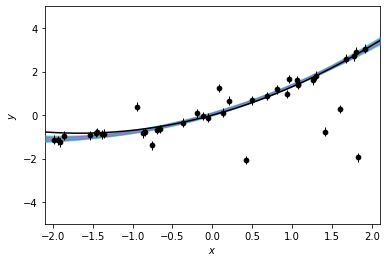

In [20]:
# Compute the quantiles of the predicted line and plot them.
#
# again, we're using the fit degree now
A = np.vander(x0, deg+1)
ddim = deg+1
lines = np.dot(sampler.flatchain[:, :ddim], A.T)
quantiles = np.percentile(lines, [16, 84, 6.70, 93.3], axis=0)
pl.fill_between(x0, quantiles[0], quantiles[1], color="#8d44ad", alpha=0.5, zorder=5)
pl.fill_between(x0, quantiles[-2], quantiles[-1], color="c", alpha=0.5, zorder=3)


# Plot the data.
pl.errorbar(x, y, yerr=yerr, fmt=",k", ms=0, capsize=0, lw=1, zorder=999)
pl.scatter(x, y, marker="o", s=22, c="k", zorder=1000)

# Plot the true line.
pl.plot(x0, y0, color="k", lw=1.5, zorder=2000)

pl.xlabel("$x$")
pl.ylabel("$y$")
pl.ylim(-5., 5.)
pl.xlim(-2.1, 2.1);

In [21]:
# Post-hoc computing of foreground membership probabilities, using the 
# likelihoods already computed

t1 = time.time()
print("Computing the posterior probability of being part of foreground model...")
norm = 0.0
post_prob = np.zeros(len(x))
for i in range(sampler.chain.shape[1]):
    for j in range(sampler.chain.shape[0]):
        ll_fg, ll_bg, _ = sampler.blobs[i][j]
        post_prob += np.exp(ll_fg - np.logaddexp(ll_fg, ll_bg))
        norm += 1
post_prob /= norm
print("... done in %.2e seconds" % (time.time()-t1))

Computing the posterior probability of being part of foreground model...
... done in 9.45e-01 seconds


Therefore, from left to right, the marginalized posterior probability that each point is part of the foreground model is:

In [22]:
print(", ".join(map("{0:.3f}".format, post_prob)))

0.956, 0.953, 0.937, 0.947, 0.956, 0.945, 0.932, 0.956, 0.954, 0.000, 0.941, 0.950, 0.029, 0.947, 0.949, 0.955, 0.928, 0.959, 0.949, 0.000, 0.957, 0.853, 0.000, 0.972, 0.976, 0.980, 0.925, 0.954, 0.986, 0.984, 0.986, 0.978, 0.990, 0.000, 0.000, 0.996, 0.996, 0.997, 0.000, 0.998


In [23]:
# we use this to identify "extreme" inlier and outlier points
lprob = np.argsort(post_prob)
ioutly = lprob[0]
iinly = lprob[-1]

*(dfm comment that won't apply to the "wrong" fit degree, has been removed).*

Finally, it can be useful to label outliers on the final plot so let's use a color scale on the points to show this probability. In the figure below, darker points are more likely to be drawn from the line. This plot is pretty satisfying because the model has done a good job labeling all but one outlier at high confidence!

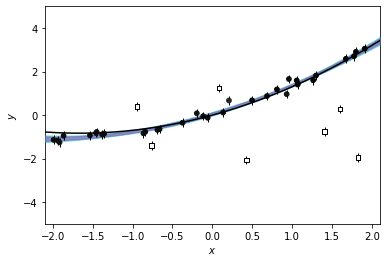

In [24]:
# Plot the prediction.
pl.fill_between(x0, quantiles[0], quantiles[1], color="#8d44ad", alpha=0.5, zorder=5)
pl.fill_between(x0, quantiles[-2], quantiles[-1], color="c", alpha=0.5, zorder=3)


# Plot the data points.
pl.errorbar(x, y, yerr=yerr, fmt=",k", ms=0, capsize=0, lw=1, zorder=999)
# Plot the (true) outliers.
pl.scatter(
    x[m_bkg],
    y[m_bkg],
    marker="s",
    s=22,
    c=post_prob[m_bkg],
    cmap="gray_r",
    edgecolor="k",
    vmin=0,
    vmax=1,
    zorder=1000,
)
# Plot the (true) good points.
pl.scatter(
    x[~m_bkg],
    y[~m_bkg],
    marker="o",
    s=22,
    c=post_prob[~m_bkg],
    cmap="gray_r",
    vmin=0,
    vmax=1,
    zorder=1000,
)

# Plot the true line.
pl.plot(x0, y0, color="k", lw=1.5, zorder=2000)

pl.xlabel("$x$")
pl.ylabel("$y$")
pl.ylim(-5., 5.)
pl.xlim(-2.1, 2.1);

## New bits: interrogating the likelihoods, using arviz, etc. ##

In [25]:
# let's look at those likelihoods. See what those indices above are doing.
print(sampler.blobs.shape)
print(sampler.chain.shape)
print("sampler.chain.shape[1]:", sampler.chain.shape[1])
print("sampler.chain.shape[0]:", sampler.chain.shape[0])

(2500, 32, 3, 40)
(32, 2500, 6)
sampler.chain.shape[1]: 2500
sampler.chain.shape[0]: 32


In [26]:
# OK so sampler.chain.shape[1] is the number of draws, and sampler.chain.shape[0] the number of chains. Fine.
#
# Let's look at one
print(sampler.blobs[0][0].shape)

(3, 40)


In [27]:
# great. That looks like two mixture components for 15 datapoints. From the above summary 
# (the posterior evaluations) we already have a good idea of which points are background
# (e.g. the [2] point). We can look at one of the ln(L) sets for this. So:
a_lnl_fg = sampler.blobs[:,:,0,:]
a_lnl_bg = sampler.blobs[:,:,1,:]

Text(0.5, 1.0, 'probable OUTLIER: 38')

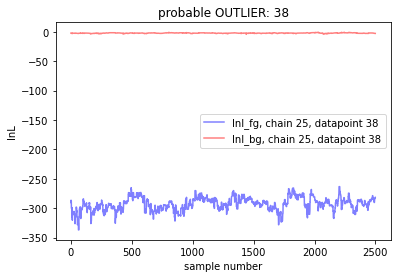

In [28]:
# Look at a point that we think belongs to the background...
jchain=25

pl.plot(a_lnl_fg[:,jchain,ioutly], label='lnl_fg, chain %i, datapoint %i' % (jchain, ioutly), alpha=0.5, color='b')
pl.plot(a_lnl_bg[:,jchain,ioutly], label='lnl_bg, chain %i, datapoint %i' % (jchain, ioutly), alpha=0.5, color='r')
pl.xlabel('sample number')
pl.ylabel('lnL')
pl.legend()
pl.title('probable OUTLIER: %i' % (ioutly))

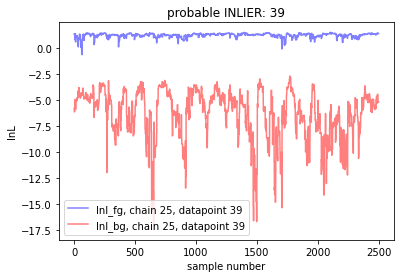

In [29]:
#... and the foreground
pl.plot(a_lnl_fg[:,jchain,iinly], label='lnl_fg, chain %i, datapoint %i' % (jchain, iinly), alpha=0.5, color='b')
pl.plot(a_lnl_bg[:,jchain,iinly], label='lnl_bg, chain %i, datapoint %i' % (jchain, iinly), alpha=0.5, color='r')
pl.xlabel('sample number')
pl.ylabel('lnL')
pl.title('probable INLIER: %i' % (iinly))
pl.legend()

In [30]:
# ok interesting. Now let's sum along the dataset (mimicking the sum ln(L) statistic) for the two populations
sum_lnL_fg = np.sum(a_lnl_fg, axis=2)
sum_lnL_bg = np.sum(a_lnl_bg, axis=2)
print(sum_lnL_fg.shape)

(2500, 32)


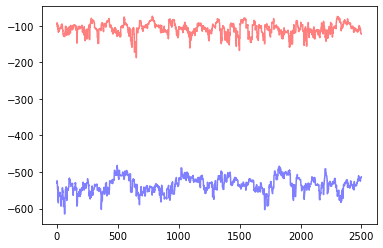

In [31]:
# plot those sums
pl.plot(sum_lnL_fg[:,jchain],label='sum(lnl_fg), chain %i' % (jchain), alpha=0.5, color='b' )
pl.plot(sum_lnL_bg[:,jchain],label='sum(lnl_bg), chain %i' % (jchain), alpha=0.5, color='r' )

In [32]:
import arviz as az


In [33]:
# Attempting to format for arviz
idata = az.from_emcee(sampler, blob_names=["lnl", "lnprior", "lnlvec"])

array([[<AxesSubplot:title={'center':'var_0'}>,
        <AxesSubplot:title={'center':'var_0'}>],
       [<AxesSubplot:title={'center':'var_1'}>,
        <AxesSubplot:title={'center':'var_1'}>],
       [<AxesSubplot:title={'center':'var_2'}>,
        <AxesSubplot:title={'center':'var_2'}>],
       [<AxesSubplot:title={'center':'var_3'}>,
        <AxesSubplot:title={'center':'var_3'}>],
       [<AxesSubplot:title={'center':'var_4'}>,
        <AxesSubplot:title={'center':'var_4'}>],
       [<AxesSubplot:title={'center':'var_5'}>,
        <AxesSubplot:title={'center':'var_5'}>]], dtype=object)

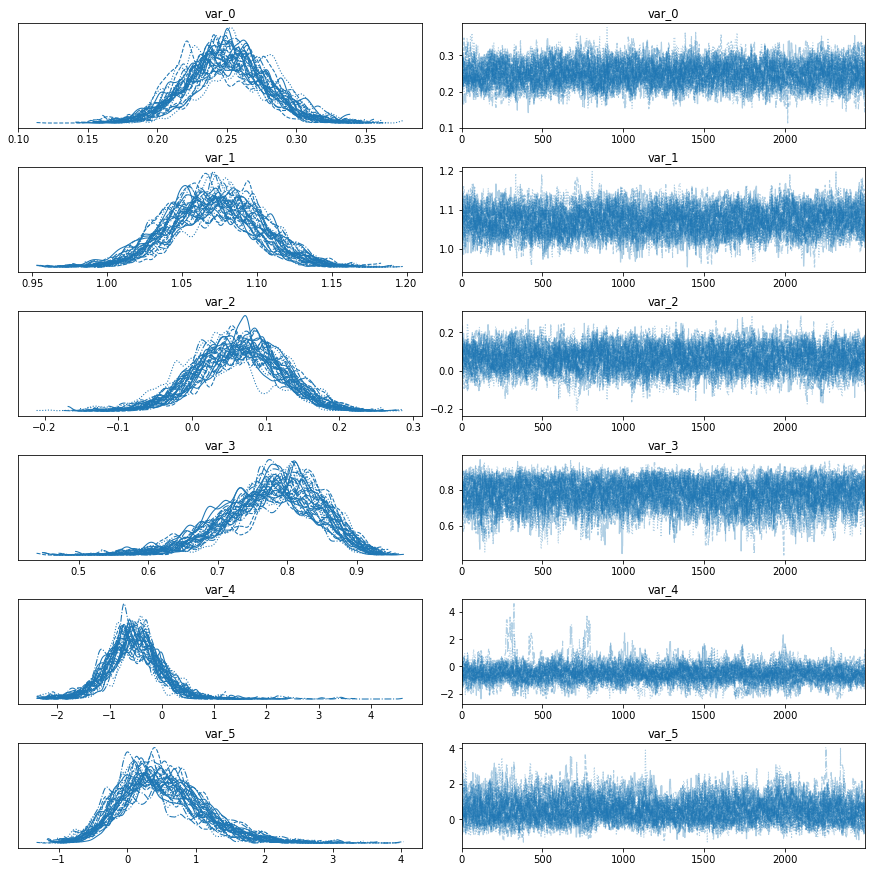

In [34]:
az.plot_trace(idata)

In [35]:
az.waic(idata, var_name="lnlvec")

/Users/wiclarks/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:1468: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


Computed from 80000 by 40 log-likelihood matrix

          Estimate       SE
elpd_waic    16.86     8.98
p_waic        3.72        -

There has been a warning during the calculation. Please check the results.

In [36]:
# output the result so we can load it into arviz for the model
# comparison later
import pickle
print("Writing samples to %s" % (path_samples_out))
pickle.dump(sampler, open(path_samples_out, 'wb'))

Writing samples to samples_ndata40_outly2.0_gen2_fit2.pickle


In [37]:
# !ls -lh *pickle

## Loop through fit degrees ##

While showing the results for a single degree **is** helpful, we will likely also want to loop through fit degrees. We do that here.

In [38]:
import numpy as np
degs = np.arange(7, dtype='int')


In [39]:
# loop through the degrees
t00 = time.time()
for deg in degs:
    p0 = genguess(deg)
    bounds = getbounds(deg)
    npars = np.asarray(bounds).shape[0]
    
    # generate filename for output sampler
    ssamples = 'ndata%i_seed%i_outly%.1f_gen%i_fit%i' % (ndata, ranseed, sigma_outly, deg_gen, deg)
    
    ndim, nwalkers = npars, 32
    p0 = [p0 + 1e-5 * np.random.randn(ndim) for k in range(nwalkers)]

    # Set up the sampler.
    sampler = None
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)   

    # run the sampler...
    state = sampler.run_mcmc(p0, burnin);
    t0 = time.time()
    sampler.reset()
    sampler.run_mcmc(state, chainlen);
    t1 = time.time()
    
    # save the sampler to disk
    path_samples_out = 'sampler_%s.pickle' % (ssamples)
    pickle.dump(sampler, open(path_samples_out, 'wb'))
    
    # produce screen output
    print("%i: %s, done in %.2e seconds" % (deg, ssamples, t1-t0))
    
print("INFO - entire superloop with seed %i took %.2e seconds" % (ranseed, time.time()-t00))

0: ndata40_seed12_outly2.0_gen2_fit0, done in 6.32e+00 seconds


/Users/wiclarks/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/Users/wiclarks/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/Users/wiclarks/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/Users/wiclarks/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/Users/wiclarks/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/Users/wiclarks/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeW

1: ndata40_seed12_outly2.0_gen2_fit1, done in 6.66e+00 seconds


/Users/wiclarks/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/Users/wiclarks/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/Users/wiclarks/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/Users/wiclarks/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/Users/wiclarks/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/Users/wiclarks/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeW

2: ndata40_seed12_outly2.0_gen2_fit2, done in 6.45e+00 seconds


/Users/wiclarks/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/Users/wiclarks/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/Users/wiclarks/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/Users/wiclarks/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/Users/wiclarks/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/Users/wiclarks/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeW

3: ndata40_seed12_outly2.0_gen2_fit3, done in 6.67e+00 seconds


/Users/wiclarks/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/Users/wiclarks/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/Users/wiclarks/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/Users/wiclarks/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/Users/wiclarks/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/Users/wiclarks/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeW

4: ndata40_seed12_outly2.0_gen2_fit4, done in 7.13e+00 seconds


/Users/wiclarks/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/Users/wiclarks/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/Users/wiclarks/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/Users/wiclarks/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/Users/wiclarks/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/Users/wiclarks/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeW

5: ndata40_seed12_outly2.0_gen2_fit5, done in 8.05e+00 seconds


/Users/wiclarks/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/Users/wiclarks/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/Users/wiclarks/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/Users/wiclarks/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/Users/wiclarks/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/Users/wiclarks/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeW

6: ndata40_seed12_outly2.0_gen2_fit6, done in 8.35e+00 seconds
INFO - entire superloop with seed 12 took 7.90e+01 seconds
